In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
#!pip install dgl -f https://data.dgl.ai/wheels/repo.html
#!pip install dgl-cu111 dglgo -f https://data.dgl.ai/wheels/repo.html
!pip install dive-into-graphs
!pip install pydig

1.12.1+cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.nn as nn
from torch._C import dtype
from torch_geometric.nn import GCNConv
import torch_geometric.nn as gnn
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool
from torch_geometric.datasets import TUDataset
from torch_geometric.data.batch import Batch
from torch import Tensor
from torch_geometric.typing import OptPairTensor, Adj, OptTensor, Size
from torch_sparse import SparseTensor
from torch_geometric.utils import to_networkx
from torchsummary import summary
from torch.autograd import Variable
from torch_geometric.data import DataLoader
from torch_geometric.data import download_url, extract_zip
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

from keras import backend as K
from statistics import mean
from operator import add
import tensorflow as tf
from typing import Callable, Union, Tuple
from termcolor import colored
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import os
import os.path as osp


#. DGL
#import dgl
#import dgl.function as fn
#from dgl.data import GINDataset
#from dgl.nn import GNNExplainer as GNNExplainer_DGL
#from dgl.dataloading import GraphDataLoader
#from dgl.nn import AvgPooling

#. DIG
from dig.xgraph.dataset import SynGraphDataset
from dig.xgraph.method import PGExplainer
from dig.xgraph.utils.compatibility import compatible_state_dict
from dig.xgraph.method.subgraphx import PlotUtils
from dig.xgraph.method.subgraphx import MCTS
from dig.xgraph.method import SubgraphX
from dig.xgraph.models import *
#from dig.xgraph.method import GNNExplainer as GNNExplainer_DIG
#from dig.xgraph.models import GCN_2l
#from dig.xgraph.models import GlobalMeanPool

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [5]:
Explainability_name = 'SubgraphX'
Task_name = 'Node Classification'
checkpoint_directory_Classifier = "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier.pt"

In [6]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
#dataset = SynGraphDataset('./datasets', 'BA_shapes')

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
#print(np.shape(dataset))
print(data)
print(colored('===========================================================================================================', 'red'))


# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of test nodes: {data.test_mask.sum()}')
print(f'Number of val nodes: {data.val_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...



Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Number of test nodes: 1000
Number of val nodes: 500
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Done!


In [7]:
print(len(data.x[0]))
print(len(data.x))
print(len(data.y))
print(data.y[0])
print(f'MAX: {max(data.y)}')
print(f'MIN: {min(data.y)}')
print(data.x[0])
print(len(data.edge_index[0]))
print("-------------------------------------")


1433
2708
2708
tensor(3)
MAX: 6
MIN: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])
10556
-------------------------------------


In [8]:
def index_to_mask(index, size):
    mask = torch.zeros(size, dtype=torch.bool, device=index.device)
    mask[index] = 1
    return mask

In [9]:
def balanced_train_test_split(dataset):
  train_percent = 0.7
  index_list = []
  num_classes = dataset.num_classes

  for i in range(num_classes):
    index = (dataset.data.y == i).nonzero().view(-1)
    index = index[torch.randperm(index.size(0))]
    index_list.append(index)
    
  train_index = torch.cat([category_list[:int(len(category_list) * train_percent)] for category_list in index_list], dim=0)
  test_index = torch.cat([category_list[int(len(category_list) * train_percent):] for category_list in index_list], dim=0)

  train_index = train_index[torch.randperm(train_index.size(0))]
  test_index = test_index[torch.randperm(test_index.size(0))]

  dataset.data.train_mask = index_to_mask(train_index, size=dataset.data.num_nodes)
  dataset.data.test_mask = index_to_mask(test_index, size=dataset.data.num_nodes)
  
  dataset.data, dataset.slices = dataset.collate([dataset.data])

  return dataset

In [10]:
dataset2 = balanced_train_test_split(dataset)
dataset_SubgraphX = dataset2[0]
print(dataset_SubgraphX)
print(len(dataset_SubgraphX))
print(len(dataset_SubgraphX.x[dataset_SubgraphX.train_mask]))
print(len(dataset_SubgraphX.x[dataset_SubgraphX.test_mask]))

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
6
1891
817


# **GCN MODEL**

In [11]:
class GNNPool(nn.Module):
    def __init__(self):
        super().__init__()

In [12]:
class GlobalMeanPool(GNNPool):

    def __init__(self):
        super().__init__()

    def forward(self, x, batch):
        return gnn.global_mean_pool(x, batch)

In [13]:
class IdenticalPool(GNNPool):

    def __init__(self):
        super().__init__()

    def forward(self, x, batch):
        return x

In [14]:
class GNNBasic(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def arguments_read(self, *args, **kwargs):

        data: Batch = kwargs.get('data') or None

        if not data:
            if not args:
                assert 'x' in kwargs
                assert 'edge_index' in kwargs
                x, edge_index = kwargs['x'], kwargs['edge_index'],
                batch = kwargs.get('batch')
                if batch is None:
                    batch = torch.zeros(kwargs['x'].shape[0], dtype=torch.int64, device=x.device)
            elif len(args) == 2:
                x, edge_index = args[0], args[1]
                batch = torch.zeros(args[0].shape[0], dtype=torch.int64, device=x.device)
            elif len(args) == 3:
                x, edge_index, batch = args[0], args[1], args[2]
            else:
                raise ValueError(f"forward's args should take 2 or 3 arguments but got {len(args)}")
        else:
            x, edge_index, batch = data.x, data.edge_index, data.batch

        return x, edge_index, batch


In [15]:
class GCNConv(gnn.GCNConv):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.edge_weight = None
        self.weight = nn.Parameter(self.lin.weight.data.T.clone().detach())

    def forward(self, x: Tensor, edge_index: Adj,
                edge_weight: OptTensor = None) -> Tensor:
        """"""

        if self.normalize and edge_weight is None:
            if isinstance(edge_index, Tensor):
                cache = self._cached_edge_index
                if cache is None:
                    edge_index, edge_weight = gnn.conv.gcn_conv.gcn_norm(  # yapf: disable
                        edge_index, edge_weight, x.size(self.node_dim),
                        self.improved, self.add_self_loops, dtype=x.dtype)
                    if self.cached:
                        self._cached_edge_index = (edge_index, edge_weight)
                else:
                    edge_index, edge_weight = cache[0], cache[1]

            elif isinstance(edge_index, SparseTensor):
                cache = self._cached_adj_t
                if cache is None:
                    edge_index = gnn.conv.gcn_conv.gcn_norm(  # yapf: disable
                        edge_index, edge_weight, x.size(self.node_dim),
                        self.improved, self.add_self_loops, dtype=x.dtype)
                    if self.cached:
                        self._cached_adj_t = edge_index
                else:
                    edge_index = cache

        # --- add require_grad ---
        edge_weight.requires_grad_(True)

        x = torch.matmul(x, self.weight)

        # propagate_type: (x: Tensor, edge_weight: OptTensor)
        out = self.propagate(edge_index, x=x, edge_weight=edge_weight,
                             size=None)

        if self.bias is not None:
            out += self.bias

        # --- My: record edge_weight ---
        self.edge_weight = edge_weight

        return out

    def propagate(self, edge_index: Adj, size: Size = None, **kwargs):
        size = self.__check_input__(edge_index, size)

        # Run "fused" message and aggregation (if applicable).
        if (isinstance(edge_index, SparseTensor) and self.fuse
                and not self._explain):
            coll_dict = self.__collect__(self.__fused_user_args__, edge_index,
                                         size, kwargs)

            msg_aggr_kwargs = self.inspector.distribute(
                'message_and_aggregate', coll_dict)
            out = self.message_and_aggregate(edge_index, **msg_aggr_kwargs)

            update_kwargs = self.inspector.distribute('update', coll_dict)
            return self.update(out, **update_kwargs)

        # Otherwise, run both functions in separation.
        elif isinstance(edge_index, Tensor) or not self.fuse:
            coll_dict = self.__collect__(self.__user_args__, edge_index, size,
                                         kwargs)

            msg_kwargs = self.inspector.distribute('message', coll_dict)
            out = self.message(**msg_kwargs)

            # For `GNNExplainer`, we require a separate message and aggregate
            # procedure since this allows us to inject the `edge_mask` into the
            # message passing computation scheme.
            if self._explain:
                edge_mask = self.__edge_mask__
                # Some ops add self-loops to `edge_index`. We need to do the
                # same for `edge_mask` (but do not train those).
                if out.size(self.node_dim) != edge_mask.size(0):
                    loop = edge_mask.new_ones(size[0])
                    edge_mask = torch.cat([edge_mask, loop], dim=0)
                assert out.size(self.node_dim) == edge_mask.size(0)
                out = out * edge_mask.view([-1] + [1] * (out.dim() - 1))

            aggr_kwargs = self.inspector.distribute('aggregate', coll_dict)
            out = self.aggregate(out, **aggr_kwargs)

            update_kwargs = self.inspector.distribute('update', coll_dict)
            return self.update(out, **update_kwargs)


In [16]:
class GCN_2l_Model(GNNBasic):

    def __init__(self, model_level, dim_node, dim_hidden, dim_output):
        super().__init__()
        num_layer = 2

        self.gconv1 = GCNConv(dim_node, dim_hidden)
        self.relu1 = nn.ReLU() 
        
        self.gconv2 = GCNConv(dim_node, dim_hidden)
        self.relu2 = nn.ReLU()

        if model_level == 'node':
            self.readout = IdenticalPool()
        else:
            self.readout = GlobalMeanPool()

        self.ffn = nn.Linear(dim_hidden, dim_output)

        self.dropout = nn.Dropout()

    def forward(self, *args, **kwargs) -> torch.Tensor:
        """
        :param Required[data]: Batch - input data
        :return:
        """
        x, edge_index, batch = self.arguments_read(*args, **kwargs)

        post_conv1 = self.relu1(self.gconv1(x, edge_index))
        post_conv2 = self.relu2(self.gconv2(x, edge_index))

        out_readout = self.readout(post_conv2, batch)

        out = self.ffn(out_readout)

        return out

    def get_emb(self, *args, **kwargs) -> torch.Tensor:
        x, edge_index, batch = self.arguments_read(*args, **kwargs)
        
        post_conv1 = self.relu1(self.gconv1(x, edge_index))
        post_conv2 = self.relu2(self.gconv2(x, edge_index))
            
        return post_conv2

GCN_2l_Model(
  (gconv1): GCNConv(1433, 100)
  (relu1): ReLU()
  (gconv2): GCNConv(1433, 100)
  (relu2): ReLU()
  (readout): IdenticalPool()
  (ffn): Linear(in_features=100, out_features=7, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


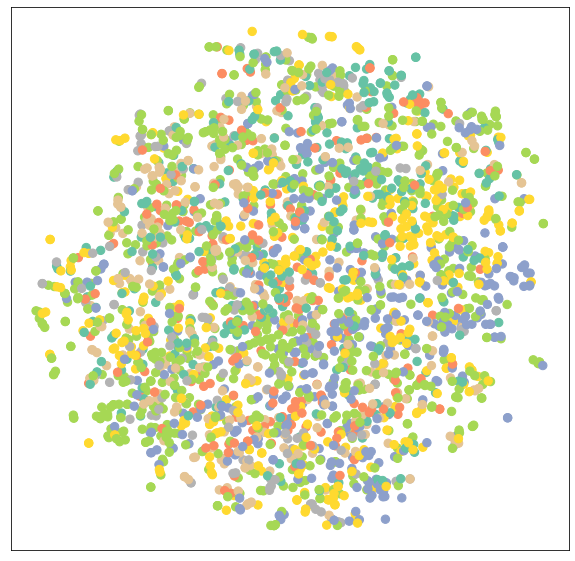

In [17]:
GCN_Model = GCN_2l_Model(model_level='node', dim_node=1433, dim_hidden=100, dim_output=dataset2.num_classes)
print(GCN_Model)
#GCN_Model = GCN(16)
GCN_Model.eval()

out = GCN_Model(dataset_SubgraphX.x, dataset_SubgraphX.edge_index)
visualize(out, color=data.y)


In [18]:
GCN_Model_Optimizer = torch.optim.Adam(GCN_Model.parameters(), lr=0.01, weight_decay=5e-4)

In [19]:
criterion = torch.nn.CrossEntropyLoss()
def loss_calculations(preds, gtruth):
  loss_per_epoch = criterion(preds, gtruth)
  return loss_per_epoch


In [20]:
def loading_model(load_index):
  GCN_Model = GCN_2l_Model(model_level='node', dim_node=1433, dim_hidden=100, num_classes=7)
  GCN_Model_Optimizer = torch.optim.Adam(params = GCN_Model.parameters(), lr=0.01)
  checkpoint = torch.load("/content/drive/My Drive/Explainability Methods/"+str(Explainability_name)+" on " + str(Task_name) + "/Model/model_classifier"+str(load_index)+".pt")
  GCN_Model.load_state_dict(checkpoint['model_state_dict'])
  GCN_Model.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']


  return GCN_Model, GCN_Model_Optimizer, epoch

In [21]:
def visualize_losses(gcn_losses, epoch_history):
  gcn_losses_list = torch.stack(gcn_losses).cpu().detach().numpy()

  fig = plt.figure(figsize=(27,20))

  ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title("`GCN Model Loss in Epoch: " + str(epoch_history))
  ax.plot(gcn_losses_list, color='r')

  plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/'+'Loss_til_epoch_{:04d}.png'.format(epoch_history))
  plt.show()  

# **Traning Configurations**

In [22]:
def train_step():
  GCN_Model.train(True)

  GCN_Model_Optimizer.zero_grad()  
  GCN_Model_out = GCN_Model(dataset_SubgraphX.x, dataset_SubgraphX.edge_index)  

  GCN_Model_loss = loss_calculations(GCN_Model_out[dataset_SubgraphX.train_mask], dataset_SubgraphX.y[dataset_SubgraphX.train_mask])  
  GCN_Model_loss.backward(retain_graph=True)

  GCN_Model_Optimizer.step()    


  return GCN_Model_loss


In [23]:
LOSS_Visualization_Parameter = 50
Model_Saving_Parameter = 100

In [24]:
#from IPython.display import Javascript  # Restrict height of output cell.
#display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))


def train(EPOCHS, load_index):
  GCN_Model_training_loss_per_epoch = []

  for epoch in range(EPOCHS):
    GCN_Model_training_loss= train_step()
    print(f'Epoch: {epoch+1:03d}, {Explainability_name} Model Loss: {GCN_Model_training_loss:.4f}')

    GCN_Model_training_loss_per_epoch.append(GCN_Model_training_loss)

    #break

    if (epoch + load_index + 1) % LOSS_Visualization_Parameter == 0 and epoch > 0:
      visualize_losses(GCN_Model_training_loss_per_epoch, epoch + load_index + 1)
    if (epoch + load_index + 1) % Model_Saving_Parameter == 0 and epoch > 0:
      torch.save({'epoch': epoch+load_index+1, 'model_state_dict': GCN_Model.state_dict(), 'optimizer_state_dict': GCN_Model_Optimizer.state_dict(), 'loss': GCN_Model_training_loss_per_epoch,}, "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier" + str(epoch + load_index + 1)+".pt")

  
  #return model_loss




Epoch: 001, SubgraphX Model Loss: 1.9411
Epoch: 002, SubgraphX Model Loss: 1.9280
Epoch: 003, SubgraphX Model Loss: 1.9125
Epoch: 004, SubgraphX Model Loss: 1.8935
Epoch: 005, SubgraphX Model Loss: 1.8717
Epoch: 006, SubgraphX Model Loss: 1.8480
Epoch: 007, SubgraphX Model Loss: 1.8238
Epoch: 008, SubgraphX Model Loss: 1.8005
Epoch: 009, SubgraphX Model Loss: 1.7800
Epoch: 010, SubgraphX Model Loss: 1.7634
Epoch: 011, SubgraphX Model Loss: 1.7504
Epoch: 012, SubgraphX Model Loss: 1.7388
Epoch: 013, SubgraphX Model Loss: 1.7252
Epoch: 014, SubgraphX Model Loss: 1.7083
Epoch: 015, SubgraphX Model Loss: 1.6889
Epoch: 016, SubgraphX Model Loss: 1.6684
Epoch: 017, SubgraphX Model Loss: 1.6481
Epoch: 018, SubgraphX Model Loss: 1.6283
Epoch: 019, SubgraphX Model Loss: 1.6088
Epoch: 020, SubgraphX Model Loss: 1.5888
Epoch: 021, SubgraphX Model Loss: 1.5680
Epoch: 022, SubgraphX Model Loss: 1.5460
Epoch: 023, SubgraphX Model Loss: 1.5230
Epoch: 024, SubgraphX Model Loss: 1.4993
Epoch: 025, Subg

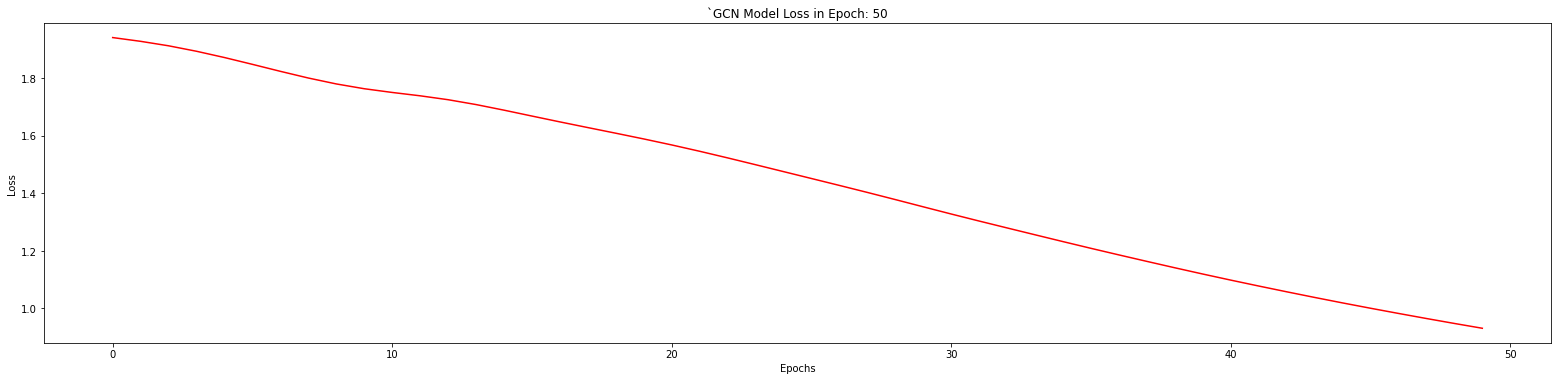

Epoch: 051, SubgraphX Model Loss: 0.9148
Epoch: 052, SubgraphX Model Loss: 0.8989
Epoch: 053, SubgraphX Model Loss: 0.8835
Epoch: 054, SubgraphX Model Loss: 0.8685
Epoch: 055, SubgraphX Model Loss: 0.8541
Epoch: 056, SubgraphX Model Loss: 0.8400
Epoch: 057, SubgraphX Model Loss: 0.8265
Epoch: 058, SubgraphX Model Loss: 0.8134
Epoch: 059, SubgraphX Model Loss: 0.8006
Epoch: 060, SubgraphX Model Loss: 0.7883
Epoch: 061, SubgraphX Model Loss: 0.7763
Epoch: 062, SubgraphX Model Loss: 0.7647
Epoch: 063, SubgraphX Model Loss: 0.7535
Epoch: 064, SubgraphX Model Loss: 0.7426
Epoch: 065, SubgraphX Model Loss: 0.7320
Epoch: 066, SubgraphX Model Loss: 0.7217
Epoch: 067, SubgraphX Model Loss: 0.7117
Epoch: 068, SubgraphX Model Loss: 0.7020
Epoch: 069, SubgraphX Model Loss: 0.6927
Epoch: 070, SubgraphX Model Loss: 0.6837
Epoch: 071, SubgraphX Model Loss: 0.6750
Epoch: 072, SubgraphX Model Loss: 0.6665
Epoch: 073, SubgraphX Model Loss: 0.6583
Epoch: 074, SubgraphX Model Loss: 0.6504
Epoch: 075, Subg

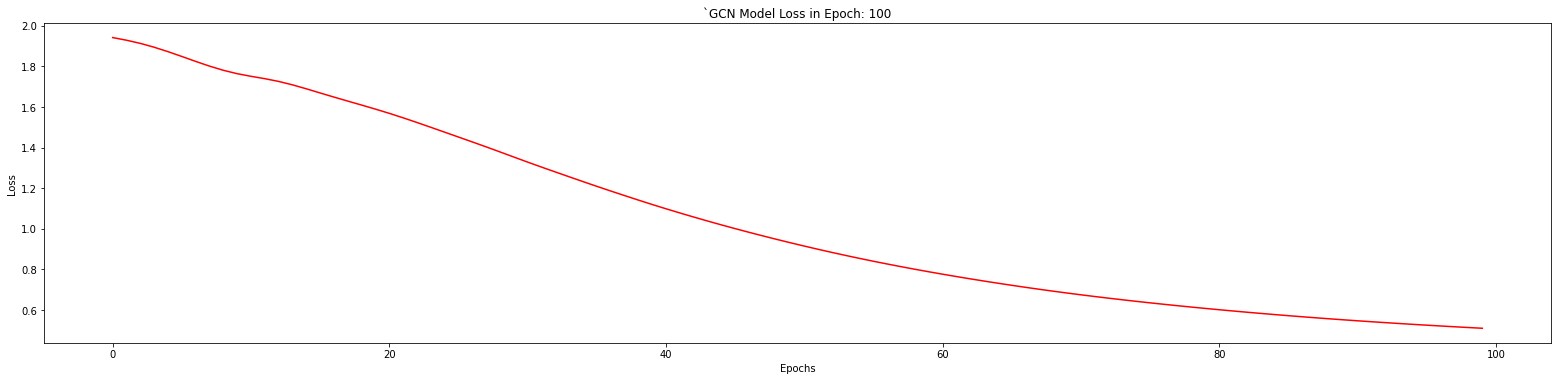

Epoch: 101, SubgraphX Model Loss: 0.5069
Epoch: 102, SubgraphX Model Loss: 0.5034
Epoch: 103, SubgraphX Model Loss: 0.5001
Epoch: 104, SubgraphX Model Loss: 0.4969
Epoch: 105, SubgraphX Model Loss: 0.4937
Epoch: 106, SubgraphX Model Loss: 0.4907
Epoch: 107, SubgraphX Model Loss: 0.4877
Epoch: 108, SubgraphX Model Loss: 0.4848
Epoch: 109, SubgraphX Model Loss: 0.4820
Epoch: 110, SubgraphX Model Loss: 0.4792
Epoch: 111, SubgraphX Model Loss: 0.4765
Epoch: 112, SubgraphX Model Loss: 0.4739
Epoch: 113, SubgraphX Model Loss: 0.4713
Epoch: 114, SubgraphX Model Loss: 0.4688
Epoch: 115, SubgraphX Model Loss: 0.4664
Epoch: 116, SubgraphX Model Loss: 0.4640
Epoch: 117, SubgraphX Model Loss: 0.4617
Epoch: 118, SubgraphX Model Loss: 0.4594
Epoch: 119, SubgraphX Model Loss: 0.4571
Epoch: 120, SubgraphX Model Loss: 0.4549
Epoch: 121, SubgraphX Model Loss: 0.4528
Epoch: 122, SubgraphX Model Loss: 0.4507
Epoch: 123, SubgraphX Model Loss: 0.4486
Epoch: 124, SubgraphX Model Loss: 0.4466
Epoch: 125, Subg

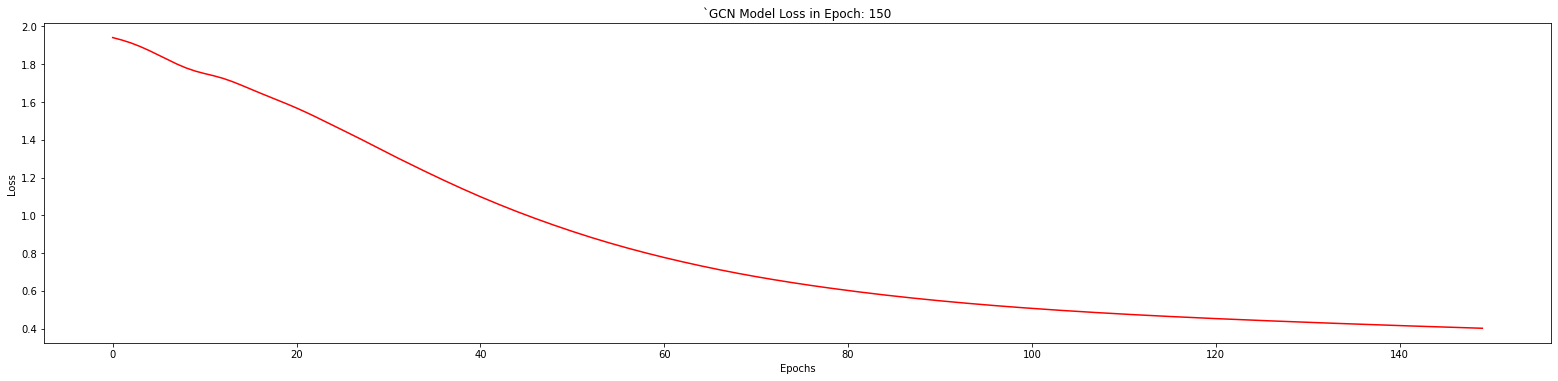

Epoch: 151, SubgraphX Model Loss: 0.4001
Epoch: 152, SubgraphX Model Loss: 0.3987
Epoch: 153, SubgraphX Model Loss: 0.3972
Epoch: 154, SubgraphX Model Loss: 0.3957
Epoch: 155, SubgraphX Model Loss: 0.3943
Epoch: 156, SubgraphX Model Loss: 0.3929
Epoch: 157, SubgraphX Model Loss: 0.3914
Epoch: 158, SubgraphX Model Loss: 0.3901
Epoch: 159, SubgraphX Model Loss: 0.3887
Epoch: 160, SubgraphX Model Loss: 0.3873
Epoch: 161, SubgraphX Model Loss: 0.3860
Epoch: 162, SubgraphX Model Loss: 0.3846
Epoch: 163, SubgraphX Model Loss: 0.3834
Epoch: 164, SubgraphX Model Loss: 0.3820
Epoch: 165, SubgraphX Model Loss: 0.3807
Epoch: 166, SubgraphX Model Loss: 0.3795
Epoch: 167, SubgraphX Model Loss: 0.3782
Epoch: 168, SubgraphX Model Loss: 0.3770
Epoch: 169, SubgraphX Model Loss: 0.3757
Epoch: 170, SubgraphX Model Loss: 0.3745
Epoch: 171, SubgraphX Model Loss: 0.3734
Epoch: 172, SubgraphX Model Loss: 0.3721
Epoch: 173, SubgraphX Model Loss: 0.3710
Epoch: 174, SubgraphX Model Loss: 0.3698
Epoch: 175, Subg

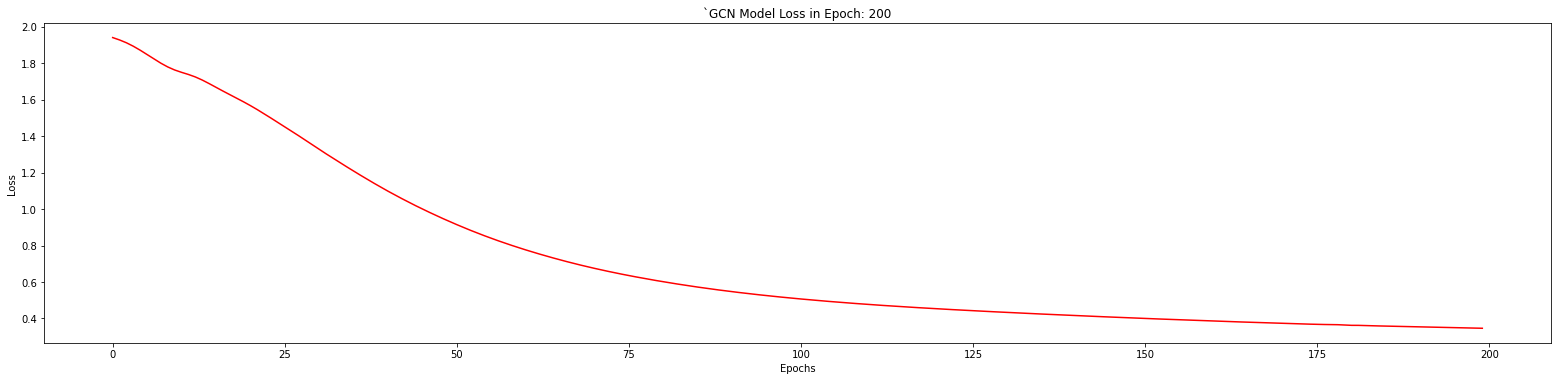

In [25]:
EPOCHS = 200
load_index = 0
if load_index is not 0:
  GCN_Model, GCN_Model_Optimizer, load_index = loading_model(load_index)
train(EPOCHS, load_index)

# **Test Configuration for the Model**

In [26]:
def GCN_Model_test():
  GCN_Model.eval()
  GCN_Model_out = GCN_Model(dataset_SubgraphX.x, dataset_SubgraphX.edge_index)
  GCN_Model_pred = GCN_Model_out.argmax(dim=1) 
  GCN_Model_test_correct = GCN_Model_pred[dataset_SubgraphX.test_mask] == dataset_SubgraphX.y[dataset_SubgraphX.test_mask] 
  GCN_Model_test_acc = int(GCN_Model_test_correct.sum()) / int(dataset_SubgraphX.test_mask.sum())
  return GCN_Model_test_acc

In [27]:
GCN_Model_test_acc = GCN_Model_test()
print(f'Test Accuracy: {GCN_Model_test_acc:.4f}')

Test Accuracy: 0.8752


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


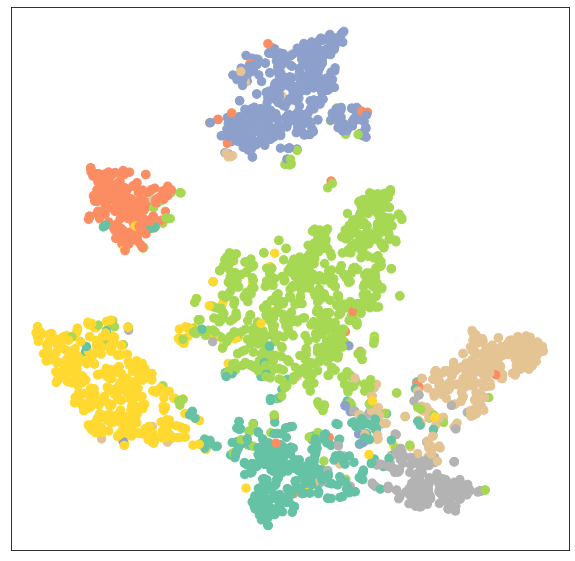

In [28]:
GCN_Model.eval()

GCN_Model_test_out = GCN_Model(dataset_SubgraphX.x, dataset_SubgraphX.edge_index)
visualize(GCN_Model_test_out, color = dataset_SubgraphX.y)

# **Index List of each Category**

In [29]:
Train_Nodes_Index_List = []
for i in range(len(dataset_SubgraphX.x)):
  if dataset_SubgraphX.train_mask[i]:
    Train_Nodes_Index_List.append(i)

Test_Nodes_Index_List = []
for i in range(len(dataset_SubgraphX.x)):
  if dataset_SubgraphX.test_mask[i]:
    Test_Nodes_Index_List.append(i)

In [30]:
print(Train_Nodes_Index_List)
print(Test_Nodes_Index_List)

[0, 1, 7, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 24, 26, 29, 30, 31, 32, 34, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 52, 55, 57, 58, 59, 60, 61, 64, 66, 67, 68, 69, 70, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 84, 86, 87, 89, 90, 91, 92, 93, 95, 98, 99, 101, 102, 104, 106, 107, 110, 111, 112, 113, 114, 115, 117, 119, 122, 123, 124, 125, 126, 127, 128, 130, 131, 132, 134, 136, 137, 138, 139, 140, 141, 143, 145, 146, 147, 150, 151, 152, 154, 155, 156, 157, 158, 159, 160, 162, 167, 168, 170, 171, 172, 173, 174, 175, 178, 182, 184, 185, 186, 189, 190, 191, 192, 195, 196, 197, 198, 199, 201, 202, 204, 206, 208, 209, 211, 213, 214, 215, 219, 220, 221, 222, 223, 225, 227, 228, 229, 231, 236, 237, 238, 239, 240, 241, 243, 244, 245, 246, 247, 251, 253, 255, 256, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 274, 276, 277, 278, 279, 281, 282, 283, 285, 286, 287, 288, 291, 292, 294, 295, 296, 297, 298, 300, 301, 302, 303, 304, 306, 307, 309, 311, 312, 313, 314, 

In [31]:
print(len(dataset2.data))
print(len(dataset_SubgraphX.x))
print(dataset_SubgraphX.keys)
print('whole dataset: ', len(dataset_SubgraphX.train_mask))
print('training dataset: ', len(dataset_SubgraphX.x[dataset_SubgraphX.train_mask]))
print('test dataset: ', len(dataset_SubgraphX.x[dataset_SubgraphX.test_mask]))


6
2708
['x', 'test_mask', 'val_mask', 'edge_index', 'y', 'train_mask']
whole dataset:  2708
training dataset:  1891
test dataset:  817


In [32]:
print(len(Train_Nodes_Index_List))
print(len(Test_Nodes_Index_List))
print()
print(Train_Nodes_Index_List)
print(Test_Nodes_Index_List)

1891
817

[0, 1, 7, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 24, 26, 29, 30, 31, 32, 34, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 52, 55, 57, 58, 59, 60, 61, 64, 66, 67, 68, 69, 70, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 84, 86, 87, 89, 90, 91, 92, 93, 95, 98, 99, 101, 102, 104, 106, 107, 110, 111, 112, 113, 114, 115, 117, 119, 122, 123, 124, 125, 126, 127, 128, 130, 131, 132, 134, 136, 137, 138, 139, 140, 141, 143, 145, 146, 147, 150, 151, 152, 154, 155, 156, 157, 158, 159, 160, 162, 167, 168, 170, 171, 172, 173, 174, 175, 178, 182, 184, 185, 186, 189, 190, 191, 192, 195, 196, 197, 198, 199, 201, 202, 204, 206, 208, 209, 211, 213, 214, 215, 219, 220, 221, 222, 223, 225, 227, 228, 229, 231, 236, 237, 238, 239, 240, 241, 243, 244, 245, 246, 247, 251, 253, 255, 256, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 274, 276, 277, 278, 279, 281, 282, 283, 285, 286, 287, 288, 291, 292, 294, 295, 296, 297, 298, 300, 301, 302, 303, 304, 306, 307, 309, 311, 312, 

In [33]:
print(Train_Nodes_Index_List)
print(len(Train_Nodes_Index_List))

print(Test_Nodes_Index_List)
print(len(Test_Nodes_Index_List))

#print(len(dataset_PGExplainer.x[0]))

[0, 1, 7, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 24, 26, 29, 30, 31, 32, 34, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 52, 55, 57, 58, 59, 60, 61, 64, 66, 67, 68, 69, 70, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 84, 86, 87, 89, 90, 91, 92, 93, 95, 98, 99, 101, 102, 104, 106, 107, 110, 111, 112, 113, 114, 115, 117, 119, 122, 123, 124, 125, 126, 127, 128, 130, 131, 132, 134, 136, 137, 138, 139, 140, 141, 143, 145, 146, 147, 150, 151, 152, 154, 155, 156, 157, 158, 159, 160, 162, 167, 168, 170, 171, 172, 173, 174, 175, 178, 182, 184, 185, 186, 189, 190, 191, 192, 195, 196, 197, 198, 199, 201, 202, 204, 206, 208, 209, 211, 213, 214, 215, 219, 220, 221, 222, 223, 225, 227, 228, 229, 231, 236, 237, 238, 239, 240, 241, 243, 244, 245, 246, 247, 251, 253, 255, 256, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 274, 276, 277, 278, 279, 281, 282, 283, 285, 286, 287, 288, 291, 292, 294, 295, 296, 297, 298, 300, 301, 302, 303, 304, 306, 307, 309, 311, 312, 313, 314, 

# **Features of Each Category**

In [34]:
training_nodes_fetures = dataset_SubgraphX.x[Train_Nodes_Index_List]
test_nodes_features = dataset_SubgraphX.x[Test_Nodes_Index_List]

print(len(training_nodes_fetures))
print(len(test_nodes_features))

#print(training_nodes)

training_nodes = training_nodes_fetures.detach().cpu().numpy()
Training_Nodes_Features = training_nodes.tolist()

test_nodes = test_nodes_features.detach().cpu().numpy()
Test_Nodes_Features = test_nodes.tolist()


print(len(Training_Nodes_Features))
print(len(Test_Nodes_Features))

1891
817
1891
817


# **Eadges of each Node**
Training

In [35]:
Edges_Training_Dataset = []
first_node_edge_training_dataset = []
second_node_edge_training_dataset = []
scnd_node_edge_training_dataset = []

print("Number of Whole Edges: ", len(dataset_SubgraphX.edge_index[0]))

for node_index in Train_Nodes_Index_List:
  index = (dataset_SubgraphX.edge_index[0] == node_index).nonzero().view(-1)
  A = dataset_SubgraphX.edge_index[0][index]
  A = A.detach().cpu().numpy()
  A = A.tolist()
  first_node_edge_training_dataset.extend(A)
  
  B = dataset_SubgraphX.edge_index[1][index]
  B = B.detach().cpu().numpy()
  B = B.tolist()
  second_node_edge_training_dataset.extend(B)
  scnd_node_edge_training_dataset.append(B)


print(len(first_node_edge_training_dataset))
print(len(second_node_edge_training_dataset))
print(first_node_edge_training_dataset)
print(second_node_edge_training_dataset)

Number of Whole Edges:  10556
7249
7249
[0, 0, 0, 1, 1, 1, 7, 11, 11, 12, 12, 12, 12, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 16, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 20, 20, 20, 20, 20, 22, 22, 22, 22, 22, 24, 24, 24, 24, 24, 24, 24, 26, 26, 26, 26, 26, 29, 29, 30, 30, 30, 30, 30, 30, 31, 32, 32, 32, 32, 34, 36, 36, 36, 36, 36, 36, 36, 36, 37, 37, 37, 38, 38, 38, 38, 39, 39, 39, 39, 39, 39, 39, 40, 40, 40, 41, 41, 41, 41, 42, 42, 43, 43, 43, 43, 43, 43, 45, 45, 45, 45, 45, 45, 46, 46, 47, 47, 48, 48, 48, 48, 48, 48, 48, 48, 48, 49, 49, 50, 52, 52, 52, 52, 52, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 57, 58, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 60, 60, 60, 61, 61, 61, 61, 61, 64, 64, 64, 66, 67, 67, 67, 68, 68, 68, 69, 69, 69, 69, 69, 69, 69, 70, 70, 72, 72, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 74, 74, 74, 74, 74, 74, 74, 74, 74, 75, 75, 75, 75, 75, 75, 76, 76, 76, 79, 79, 80, 80, 80, 81, 81, 81, 81, 82, 82, 83, 83, 84, 84, 84, 84, 84, 86, 86, 86

In [36]:
Edges_Training_Dataset.append(first_node_edge_training_dataset)
Edges_Training_Dataset.append(second_node_edge_training_dataset)

In [37]:
print("Number of Training Edges: ", len(Edges_Training_Dataset[0]))

Number of Training Edges:  7249


# **Eadges of each Node**
Test

In [38]:
Edges_Test_Dataset = []

first_node_edge_test_dataset = []
second_node_edge_test_dataset = []

#print(len(dataset_SubgraphX.edge_index[0]))

for node in Test_Nodes_Index_List:
  index = (dataset_SubgraphX.edge_index[0] == node).nonzero().view(-1)
  A = dataset_SubgraphX.edge_index[0][index]
  A = A.detach().cpu().numpy()
  A = A.tolist()
  first_node_edge_test_dataset.extend(A)
  
  B = dataset_SubgraphX.edge_index[1][index]
  B = B.detach().cpu().numpy()
  B = B.tolist()
  second_node_edge_test_dataset.extend(B)

print(len(first_node_edge_test_dataset))
print(len(second_node_edge_test_dataset))
print(first_node_edge_test_dataset)
print(second_node_edge_test_dataset)

3307
3307
[2, 2, 2, 2, 2, 3, 4, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 8, 8, 8, 9, 9, 10, 10, 19, 21, 21, 23, 25, 25, 25, 25, 27, 27, 27, 27, 28, 33, 33, 33, 33, 33, 33, 33, 33, 33, 35, 35, 35, 44, 44, 44, 51, 51, 51, 51, 51, 51, 53, 53, 53, 54, 54, 56, 56, 56, 56, 62, 63, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 71, 71, 71, 77, 77, 78, 78, 78, 85, 85, 85, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 96, 97, 97, 100, 100, 103, 103, 103, 103, 103, 103, 105, 105, 105, 105, 108, 108, 108, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 116, 116, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 120, 120, 120, 120, 120, 121, 121, 121, 121, 121, 121, 121, 129, 129, 133, 133, 133, 133, 133, 133, 133, 133

In [39]:
Edges_Test_Dataset.append(first_node_edge_test_dataset)
Edges_Test_Dataset.append(second_node_edge_test_dataset)

In [40]:
print("Number of Test Edges: ", len(Edges_Test_Dataset[0]))

Number of Test Edges:  3307


# **Labels of each Category**

In [41]:
training_labels = dataset_SubgraphX.y[Train_Nodes_Index_List]
test_labels = dataset_SubgraphX.y[Test_Nodes_Index_List]


print(len(training_labels))
print(len(test_labels))

print(training_labels)

Training_Labels = training_labels.detach().cpu().numpy()
Training_Labels = training_labels.tolist()

Test_Labels = test_labels.detach().cpu().numpy()
Test_Labels = test_labels.tolist()


print(len(Training_Labels))
print(len(Test_Labels))

1891
817
tensor([3, 4, 3,  ..., 3, 3, 3])
1891
817


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


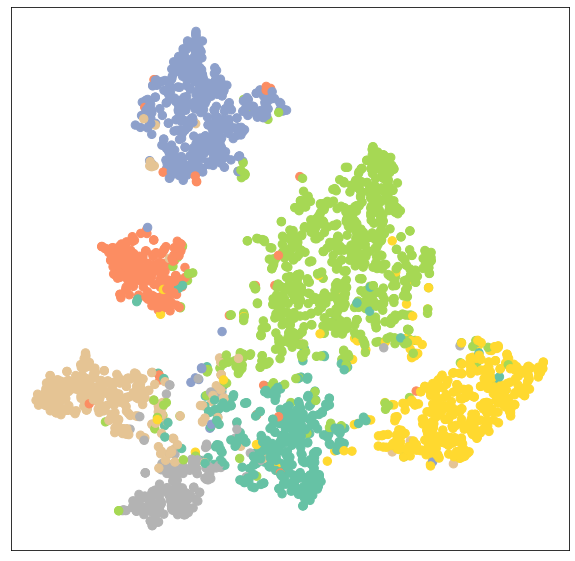

In [42]:
out = GCN_Model(dataset_SubgraphX.x, dataset_SubgraphX.edge_index)
visualize(out, color=data.y)

# **SubgraphX**


In [43]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [105]:
from dig.xgraph.method import SubgraphX
explainer_epoch = 1

SubgraphX = SubgraphX(GCN_Model, num_classes=dataset2.num_classes, device=device, num_hops=1, explain_graph=False)

In [79]:
print(dataset_SubgraphX.x[dataset_SubgraphX.test_mask][0].shape)

torch.Size([1433])


In [107]:
explanation_results, related_preds = SubgraphX(dataset_SubgraphX.x, dataset_SubgraphX.edge_index, node_index=1)

AssertionError: ignored

In [ ]:
print(explanation_results)
print(related_preds)

In [ ]:
torch.save(SubgraphX.state_dict(), "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/" + "PG_Explainer_" + "trained on " + str(explainer_epoch) + " Epoch" + ".pt")


In [ ]:
state_dict = torch.load("/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/" + "PG_Explainer_" + "trained on " + str(explainer_epoch) + " Epoch" + ".pt")
SubgraphX.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
explainer_model_state = SubgraphX.state_dict()

In [ ]:
print(len(explainer_model_state))
print(explainer_model_state.keys())

12
odict_keys(['model.gconv1.bias', 'model.gconv1.weight', 'model.gconv1.lin.weight', 'model.gconv2.bias', 'model.gconv2.weight', 'model.gconv2.lin.weight', 'model.ffn.weight', 'model.ffn.bias', 'elayers.0.0.weight', 'elayers.0.0.bias', 'elayers.1.weight', 'elayers.1.bias'])
